In [96]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [97]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [98]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [99]:
class_names = dataset.class_names
class_names

len(class_names)

3

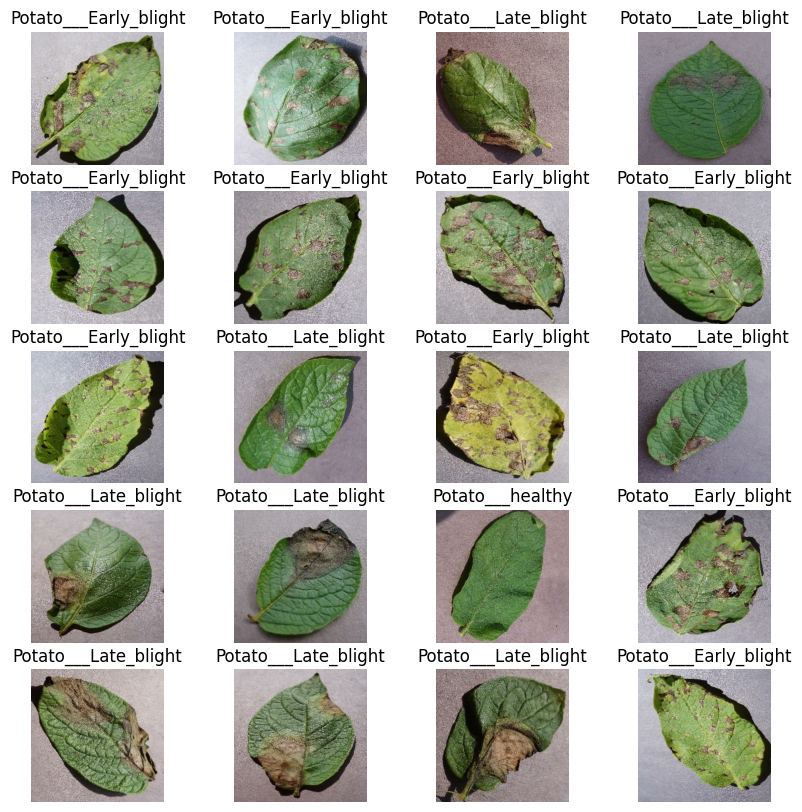

In [100]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [101]:
len(dataset)

68

In [102]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [ ]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [ ]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [ ]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [ ]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

2

In [ ]:
def get_dataset_repartition_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split*ds_size)
    
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_repartition_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Optimised performances

In [95]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [103]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [105]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])